# 2 Layer CNN 

Using PyTorch version: 2.3.1+cu121
Using GPU, device name: NVIDIA RTX A5000
Epoch [1/10], Loss: 0.4395, Accuracy: 84.58%
Epoch [2/10], Loss: 0.2991, Accuracy: 89.38%
Epoch [3/10], Loss: 0.2629, Accuracy: 90.56%
Epoch [4/10], Loss: 0.2346, Accuracy: 91.53%
Epoch [5/10], Loss: 0.2140, Accuracy: 92.17%
Epoch [6/10], Loss: 0.1968, Accuracy: 92.79%
Epoch [7/10], Loss: 0.1834, Accuracy: 93.28%
Epoch [8/10], Loss: 0.1253, Accuracy: 95.48%
Epoch [9/10], Loss: 0.1130, Accuracy: 96.06%
Epoch [10/10], Loss: 0.1053, Accuracy: 96.22%
Test Accuracy: 92.21%
Accuracy of T-shirt/top: 86.50%
Accuracy of Trouser: 98.50%
Accuracy of Pullover: 86.40%
Accuracy of Dress: 92.60%
Accuracy of Coat: 87.80%
Accuracy of Sandal: 98.70%
Accuracy of Shirt: 79.10%
Accuracy of Sneaker: 97.00%
Accuracy of Bag: 98.40%
Accuracy of Ankle boot: 97.10%


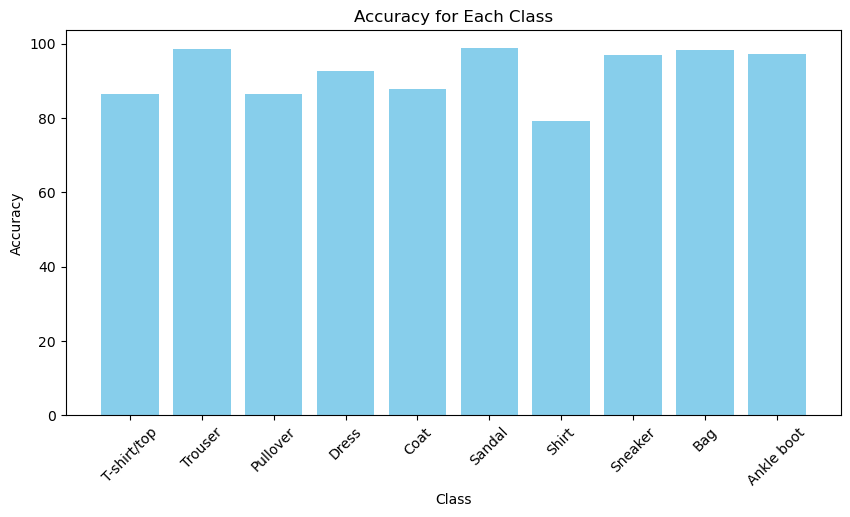

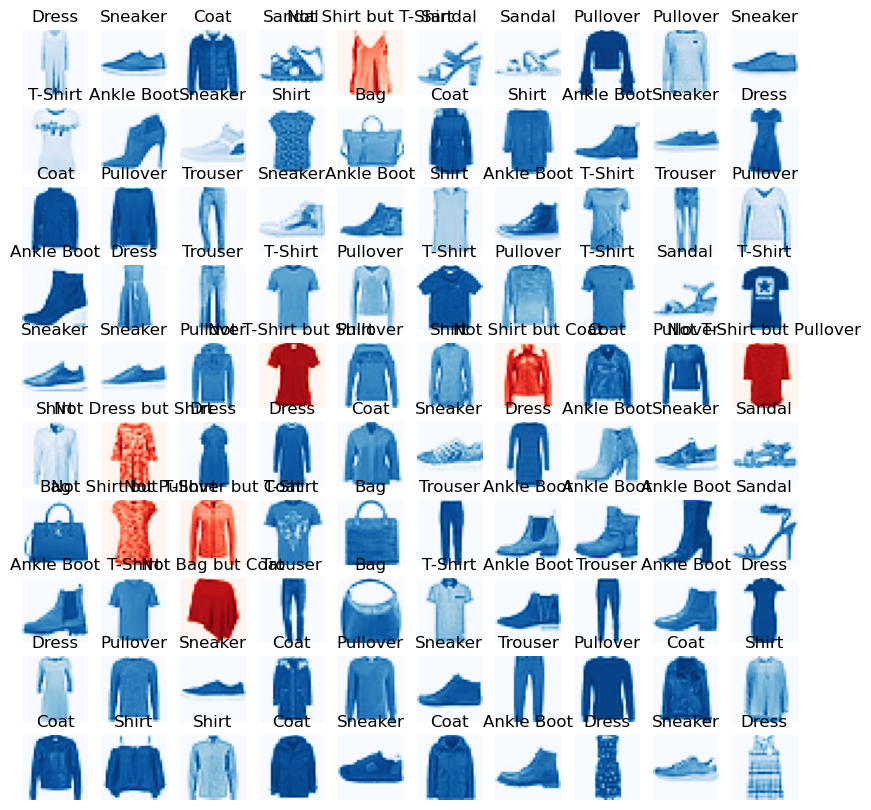

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ResNet-18 모델 불러오기
from torchvision.models import resnet18

%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 개선된 CNN 모델 정의
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( ## 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), ## 2
            nn.BatchNorm2d(32), ## 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 4
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) ## 5
        self.drop=nn.Dropout(0.25)
        self.fc2=nn.Linear(in_features=600, out_features=120)
        self.fc3=nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) ## 6
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
model = FashionCNN().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 10
rows = 10
fig = plt.figure(figsize=(10,10))
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_dataset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred)
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show()

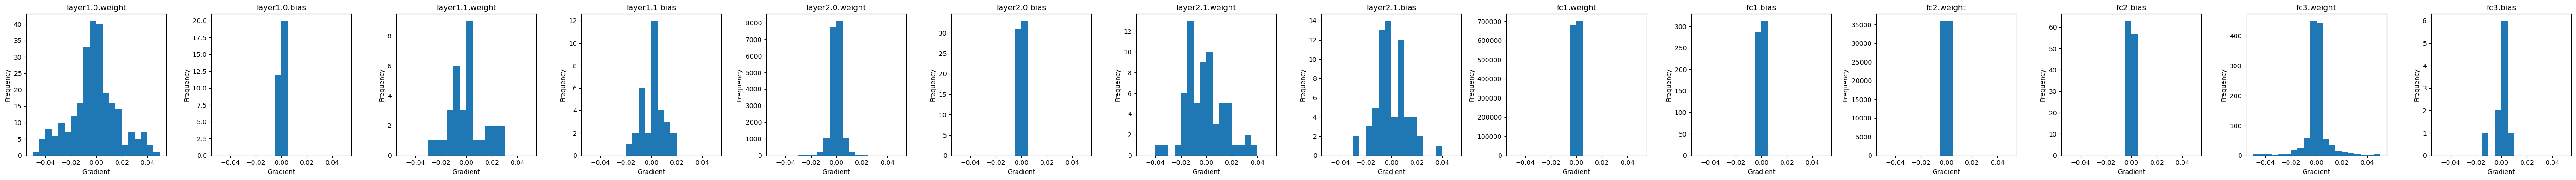

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Perform a single forward and backward pass
def get_gradients(model, data_loader, criterion, device):
    model.train()  # Set the model to training mode
    data_iter = iter(data_loader)
    inputs, labels = next(data_iter)
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()

    # Collect gradients
    gradients = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients[name] = param.grad.cpu().detach().numpy()
    
    return gradients

# Function to plot the gradients
def plot_gradients(gradients):
    num_layers = len(gradients)
    fig, axes = plt.subplots(1, num_layers, figsize=(num_layers * 4, 4))

    for idx, (name, grad) in enumerate(gradients.items()):
        ax = axes[idx] if num_layers > 1 else axes
        grad_flatten = grad.flatten()

        ax.hist(grad_flatten, bins=20, range=(-0.05, 0.05))
        ax.set_title(name)
        ax.set_xlabel('Gradient')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Get the gradients
gradients = get_gradients(model, train_loader, criterion, device)

# Plot the gradients
plot_gradients(gradients)


# ResNet

Using PyTorch version: 2.3.0+cu118
Using GPU, device name: NVIDIA RTX A5000


/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3598, Accuracy: 87.07%
Epoch [2/10], Loss: 0.2479, Accuracy: 90.94%
Epoch [3/10], Loss: 0.2078, Accuracy: 92.45%
Epoch [4/10], Loss: 0.1794, Accuracy: 93.38%
Epoch [5/10], Loss: 0.1556, Accuracy: 94.31%
Epoch [6/10], Loss: 0.1308, Accuracy: 95.08%
Epoch [7/10], Loss: 0.1121, Accuracy: 95.86%
Epoch [8/10], Loss: 0.0498, Accuracy: 98.25%
Epoch [9/10], Loss: 0.0299, Accuracy: 98.99%
Epoch [10/10], Loss: 0.0190, Accuracy: 99.38%
Test Accuracy: 93.38%
Accuracy of T-shirt/top: 90.00%
Accuracy of Trouser: 99.00%
Accuracy of Pullover: 91.00%
Accuracy of Dress: 94.20%
Accuracy of Coat: 90.40%
Accuracy of Sandal: 98.80%
Accuracy of Shirt: 76.70%
Accuracy of Sneaker: 97.40%
Accuracy of Bag: 98.50%
Accuracy of Ankle boot: 97.80%


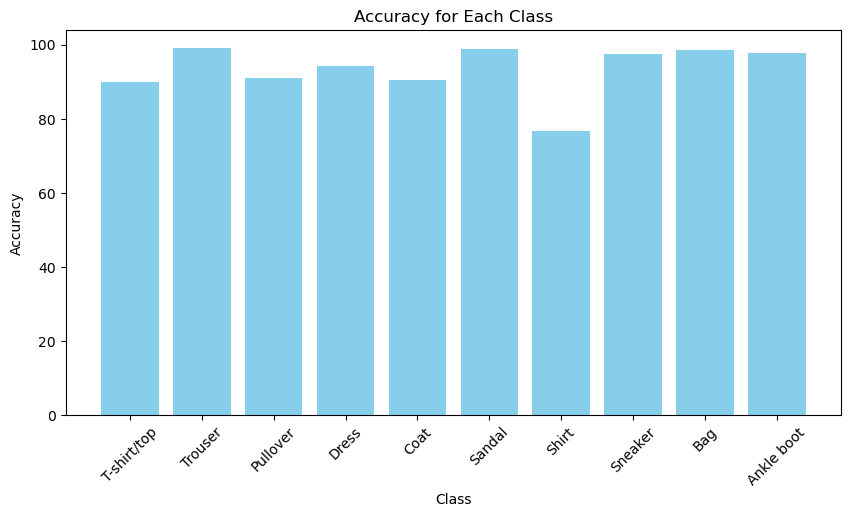

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ResNet-18 모델 불러오기
from torchvision.models import resnet18

%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 생성
class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.model = resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널을 1로 변경
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)  # 출력 크기를 10으로 변경 (10개의 클래스)
    
    def forward(self, x):
        return self.model(x)

model = FashionResNet().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)


# Improved Resnet

Using PyTorch version: 2.3.0+cu118
Using GPU, device name: NVIDIA RTX A5000
Epoch [1/10], Loss: 0.3903, Accuracy: 85.74%
Epoch [2/10], Loss: 0.2468, Accuracy: 91.00%
Epoch [3/10], Loss: 0.2077, Accuracy: 92.40%
Epoch [4/10], Loss: 0.1814, Accuracy: 93.36%
Epoch [5/10], Loss: 0.1552, Accuracy: 94.40%
Epoch [6/10], Loss: 0.1313, Accuracy: 95.25%
Epoch [7/10], Loss: 0.1101, Accuracy: 96.03%
Epoch [8/10], Loss: 0.0503, Accuracy: 98.36%
Epoch [9/10], Loss: 0.0305, Accuracy: 99.15%
Epoch [10/10], Loss: 0.0198, Accuracy: 99.55%
Test Accuracy: 93.77%
Accuracy of T-shirt/top: 88.70%
Accuracy of Trouser: 98.80%
Accuracy of Pullover: 91.10%
Accuracy of Dress: 93.30%
Accuracy of Coat: 92.40%
Accuracy of Sandal: 98.30%
Accuracy of Shirt: 81.60%
Accuracy of Sneaker: 98.50%
Accuracy of Bag: 98.80%
Accuracy of Ankle boot: 96.20%


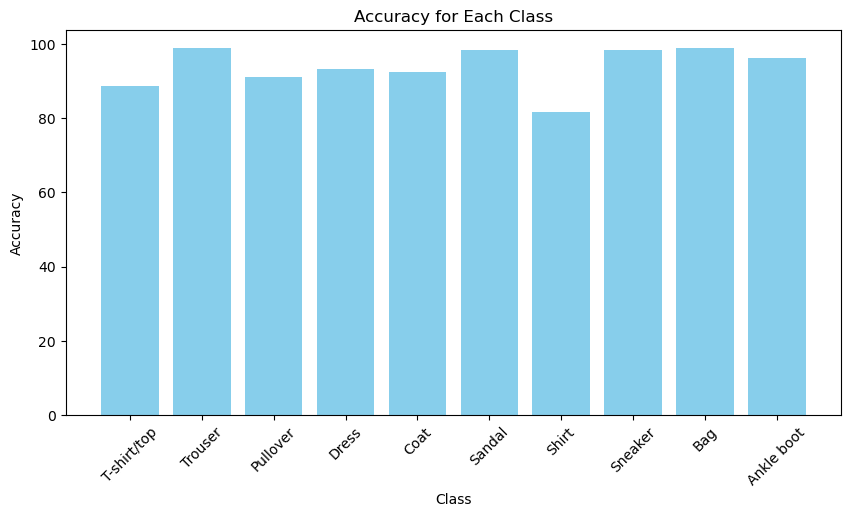

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import math

# BasicBlock 정의
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet 정의
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet-18 정의 함수
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

# Matplotlib 설정
%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 생성
class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.model = resnet18(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

model = FashionResNet().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)


/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using PyTorch version: 2.3.0+cu118
Using GPU, device name: NVIDIA RTX A5000


/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3929, Accuracy: 85.89%
Epoch [2/10], Loss: 0.2635, Accuracy: 90.39%
Epoch [3/10], Loss: 0.2201, Accuracy: 92.07%
Epoch [4/10], Loss: 0.1959, Accuracy: 92.82%
Epoch [5/10], Loss: 0.1717, Accuracy: 93.67%
Epoch [6/10], Loss: 0.1487, Accuracy: 94.53%
Epoch [7/10], Loss: 0.1611, Accuracy: 94.29%
Epoch [8/10], Loss: 0.0726, Accuracy: 97.39%
Epoch [9/10], Loss: 0.0512, Accuracy: 98.25%
Epoch [10/10], Loss: 0.0369, Accuracy: 98.74%
Test Accuracy: 93.70%
Accuracy of T-shirt/top: 90.90%
Accuracy of Trouser: 98.60%
Accuracy of Pullover: 92.30%
Accuracy of Dress: 94.20%
Accuracy of Coat: 89.50%
Accuracy of Sandal: 98.70%
Accuracy of Shirt: 78.70%
Accuracy of Sneaker: 98.00%
Accuracy of Bag: 98.70%
Accuracy of Ankle boot: 97.40%


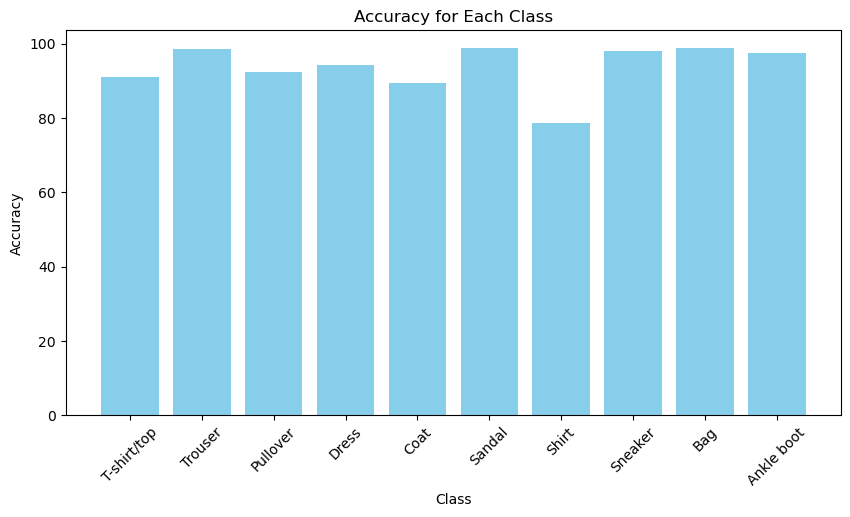

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ResNet-18 모델 불러오기
from torchvision.models import resnet34

%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
Accuracy of Shirt: 78.70%
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 생성
class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.model = resnet34(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널을 1로 변경
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)  # 출력 크기를 10으로 변경 (10개의 클래스)
    
    def forward(self, x):
        return self.model(x)

model = FashionResNet().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)


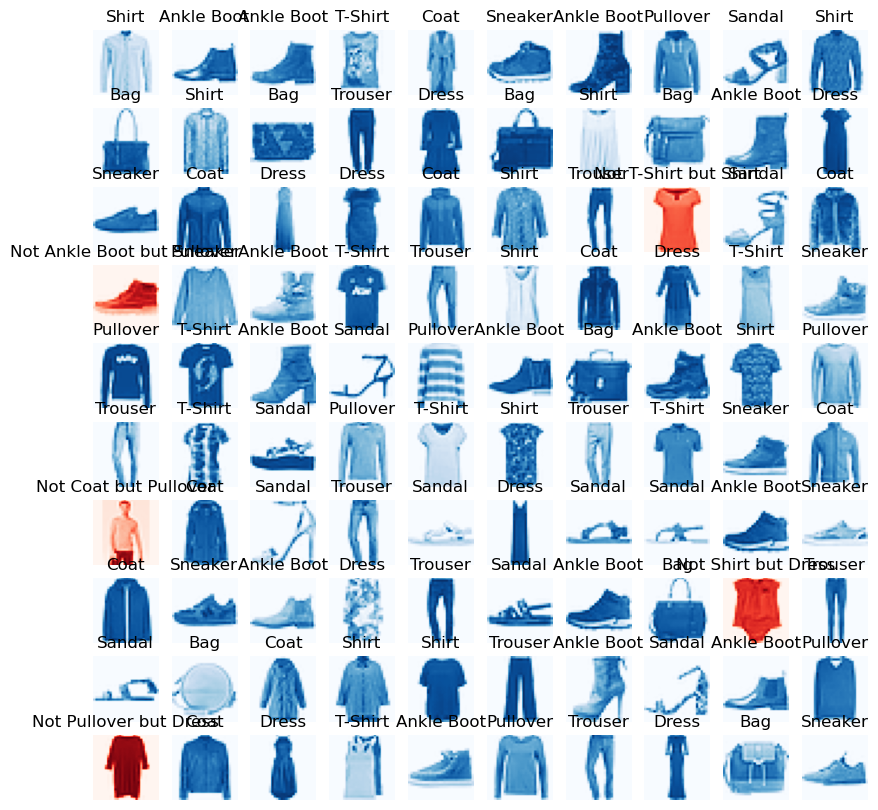

In [3]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}
columns = 10
rows = 10
fig = plt.figure(figsize=(10,10))
Accuracy of Shirt: 78.70%
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_dataset[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred)
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show()

<Figure size 1000x1000 with 0 Axes>

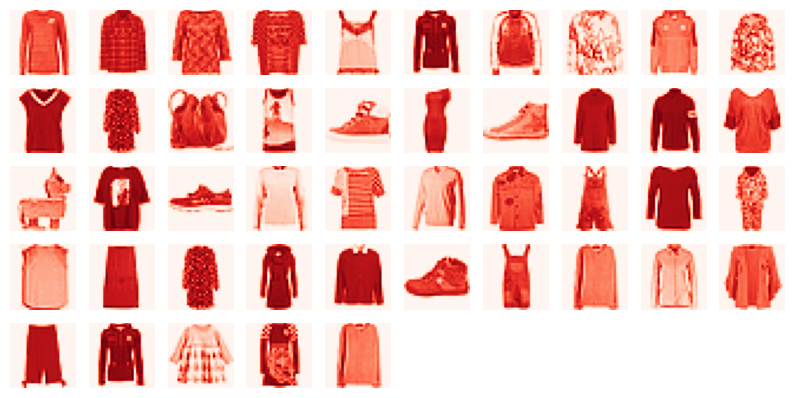

In [6]:
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
num_images = 500  # 체크할 이미지 개수
wrong_images = []  # 잘못 분류한 이미지를 저장할 리스트

# num_images 만큼 데이터셋에서 랜덤하게 선택하여 예측 및 비교
for _ in range(num_images):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_dataset[data_idx][1]]

    if pred != label:  # 잘못 분류한 경우
        wrong_images.append((data_idx, pred, label))

# 잘못 분류한 이미지를 출력
rows = columns = min(10, len(wrong_images))  # 최대 10x10개의 이미지 출력
fig = plt.figure(figsize=(10, 10))

for i, (data_idx, pred, label) in enumerate(wrong_images[:rows * columns], 1):
    fig.add_subplot(rows, columns, i)
    #plt.title('Not ' + pred + ' but ' + label)
    plot_img = test_dataset[data_idx][0][0, :, :]
    plt.imshow(plot_img, cmap='Reds')
    plt.axis('off')

plt.show()


Shirt의 경우, Pullover, Coat와 같은 카테고리에서 혼동하는 것을 확인할 수 있습니다.

사실 Shirt의 경우 Pullover, Coat와 유사한 형태를 띠고 있으며 간단하게 구현된 현재의 모델은 Shirt, Pullover, Coat에서의 특징을 다른 카테고리들에 비해 학습이 제대로 되지 않았다고도 볼 수 있습니다.

실험 결과로 예측해보면, Coat는 Coat로 올바르게 예측하지만 Shirt를 Coat, Pullover로 분류하는 경우들이 많아서 Shirt가 다른 결과에 비해 낮은 결과를 얻었다고 생각할 수 있습니다.

Epoch [1/10], Loss: 0.6019, Accuracy: 77.92%
Epoch [2/10], Loss: 0.3716, Accuracy: 86.33%
Epoch [3/10], Loss: 0.3188, Accuracy: 88.27%
Epoch [4/10], Loss: 0.2897, Accuracy: 89.27%
Epoch [5/10], Loss: 0.2678, Accuracy: 90.09%
Epoch [6/10], Loss: 0.2491, Accuracy: 90.77%
Epoch [7/10], Loss: 0.2367, Accuracy: 91.18%
Epoch [8/10], Loss: 0.2243, Accuracy: 91.60%
Epoch [9/10], Loss: 0.2125, Accuracy: 92.07%
Epoch [10/10], Loss: 0.2021, Accuracy: 92.38%
Test Accuracy: 89.91%


<Figure size 1000x1000 with 0 Axes>

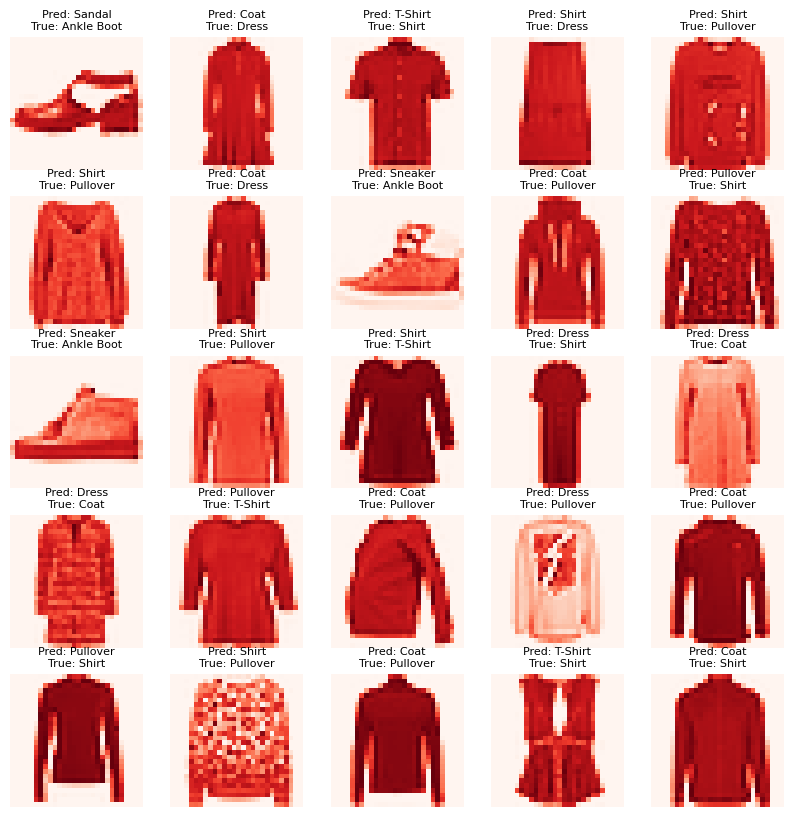

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# LeNet-5 모델 정의
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fashion MNIST 데이터셋 다운로드 및 로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델, 손실 함수, 최적화 알고리즘 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 함수 정의
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

# 모델 평가 함수 정의
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# 모델 학습 및 평가
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()


Epoch [1/20], Loss: 0.6449, Accuracy: 75.31%
Epoch [2/20], Loss: 0.4220, Accuracy: 84.42%
Epoch [3/20], Loss: 0.3609, Accuracy: 86.77%
Epoch [4/20], Loss: 0.3224, Accuracy: 88.02%
Epoch [5/20], Loss: 0.2942, Accuracy: 89.18%
Epoch [6/20], Loss: 0.2755, Accuracy: 89.75%
Epoch [7/20], Loss: 0.2582, Accuracy: 90.50%
Epoch [8/20], Loss: 0.2441, Accuracy: 90.98%
Epoch [9/20], Loss: 0.2302, Accuracy: 91.39%
Epoch [10/20], Loss: 0.2194, Accuracy: 91.83%
Epoch [11/20], Loss: 0.2083, Accuracy: 92.26%
Epoch [12/20], Loss: 0.2002, Accuracy: 92.53%
Epoch [13/20], Loss: 0.1894, Accuracy: 92.89%
Epoch [14/20], Loss: 0.1808, Accuracy: 93.12%
Epoch [15/20], Loss: 0.1728, Accuracy: 93.52%
Epoch [16/20], Loss: 0.1670, Accuracy: 93.62%
Epoch [17/20], Loss: 0.1581, Accuracy: 93.99%
Epoch [18/20], Loss: 0.1514, Accuracy: 94.25%
Epoch [19/20], Loss: 0.1458, Accuracy: 94.52%
Epoch [20/20], Loss: 0.1398, Accuracy: 94.69%
Test Accuracy: 90.55%


<Figure size 1000x1000 with 0 Axes>

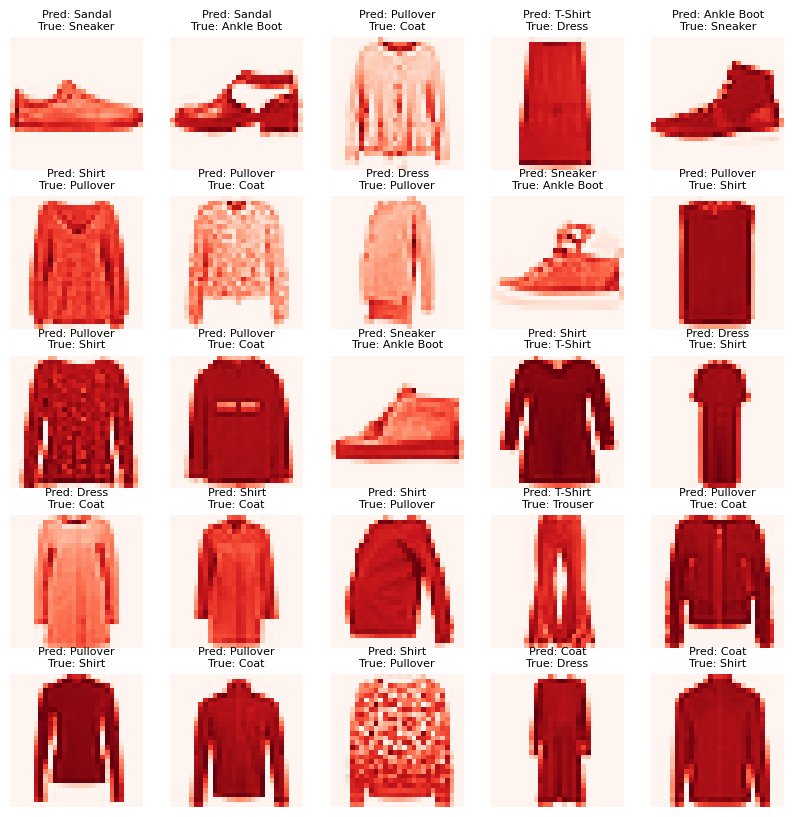

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# LeNet-5 모델 정의
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Average Pooling 사용
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fashion MNIST 데이터셋 다운로드 및 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델, 손실 함수, 최적화 알고리즘 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 함수 정의
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

# 모델 평가 함수 정의
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# 모델 학습 및 평가
train_model(model, train_loader, criterion, optimizer, device, num_epochs=20)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()


Epoch [1/20], Loss: 0.7948, Accuracy: 71.67%
Epoch [2/20], Loss: 0.5798, Accuracy: 79.06%
Epoch [3/20], Loss: 0.5237, Accuracy: 80.92%
Epoch [4/20], Loss: 0.4849, Accuracy: 82.29%
Epoch [5/20], Loss: 0.4597, Accuracy: 83.35%
Epoch [6/20], Loss: 0.4440, Accuracy: 83.97%
Epoch [7/20], Loss: 0.4292, Accuracy: 84.50%
Epoch [8/20], Loss: 0.4194, Accuracy: 84.79%
Epoch [9/20], Loss: 0.4079, Accuracy: 85.15%
Epoch [10/20], Loss: 0.4005, Accuracy: 85.57%
Epoch [11/20], Loss: 0.3670, Accuracy: 86.80%
Epoch [12/20], Loss: 0.3589, Accuracy: 87.13%
Epoch [13/20], Loss: 0.3501, Accuracy: 87.35%
Epoch [14/20], Loss: 0.3465, Accuracy: 87.53%
Epoch [15/20], Loss: 0.3443, Accuracy: 87.49%
Epoch [16/20], Loss: 0.3443, Accuracy: 87.48%
Epoch [17/20], Loss: 0.3430, Accuracy: 87.70%
Epoch [18/20], Loss: 0.3427, Accuracy: 87.56%
Epoch [19/20], Loss: 0.3405, Accuracy: 87.70%
Epoch [20/20], Loss: 0.3379, Accuracy: 87.75%
Test Accuracy: 87.98%


<Figure size 1000x1000 with 0 Axes>

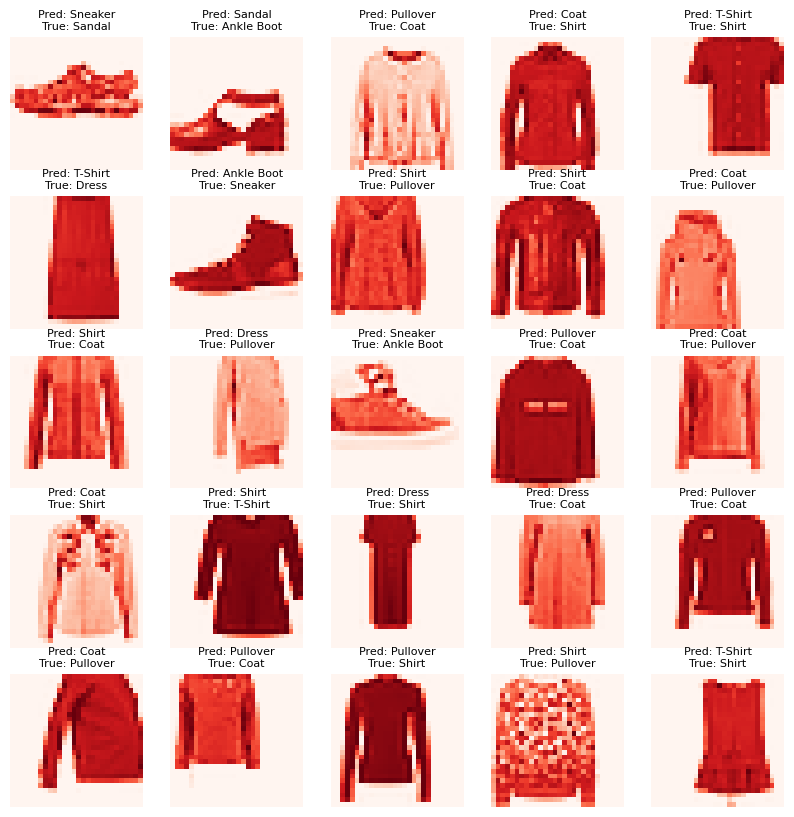

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# LeNet-5 모델 정의
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 데이터 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fashion MNIST 데이터셋 다운로드 및 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델, 손실 함수, 최적화 알고리즘 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 모델 학습 함수 정의
def train_model(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

# 모델 평가 함수 정의
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# 모델 학습 및 평가
train_model(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=20)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()


Using PyTorch version: 2.3.0+cu118
Using GPU, device name: NVIDIA RTX A5000
Epoch [1/10], Loss: 0.5328, Accuracy: 80.39%
Epoch [2/10], Loss: 0.3374, Accuracy: 87.61%
Epoch [3/10], Loss: 0.2857, Accuracy: 89.56%
Epoch [4/10], Loss: 0.2594, Accuracy: 90.52%
Epoch [5/10], Loss: 0.2413, Accuracy: 91.07%
Epoch [6/10], Loss: 0.2244, Accuracy: 91.88%
Epoch [7/10], Loss: 0.2111, Accuracy: 92.29%
Epoch [8/10], Loss: 0.1661, Accuracy: 94.14%
Epoch [9/10], Loss: 0.1558, Accuracy: 94.33%
Epoch [10/10], Loss: 0.1501, Accuracy: 94.64%
Test Accuracy: 93.80%
Accuracy of T-shirt/top: 88.30%
Accuracy of Trouser: 99.10%
Accuracy of Pullover: 90.60%
Accuracy of Dress: 94.90%
Accuracy of Coat: 91.50%
Accuracy of Sandal: 99.00%
Accuracy of Shirt: 81.00%
Accuracy of Sneaker: 97.80%
Accuracy of Bag: 99.20%
Accuracy of Ankle boot: 96.60%


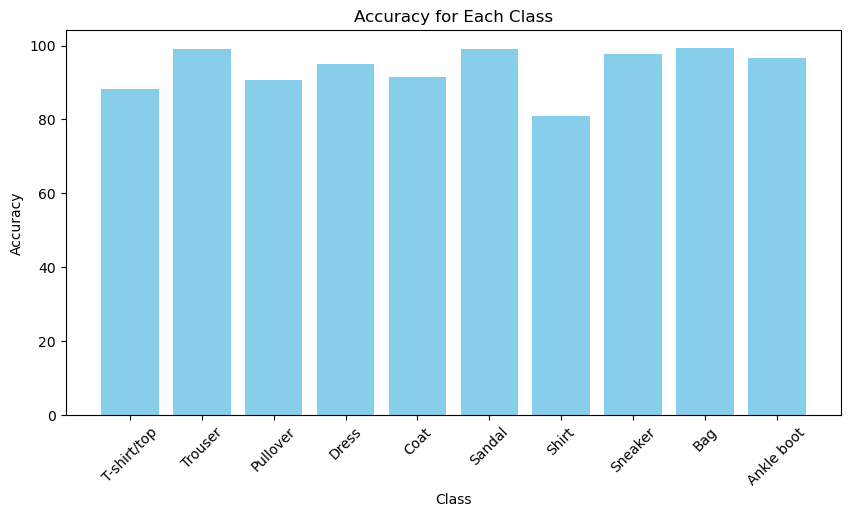

<Figure size 1000x1000 with 0 Axes>

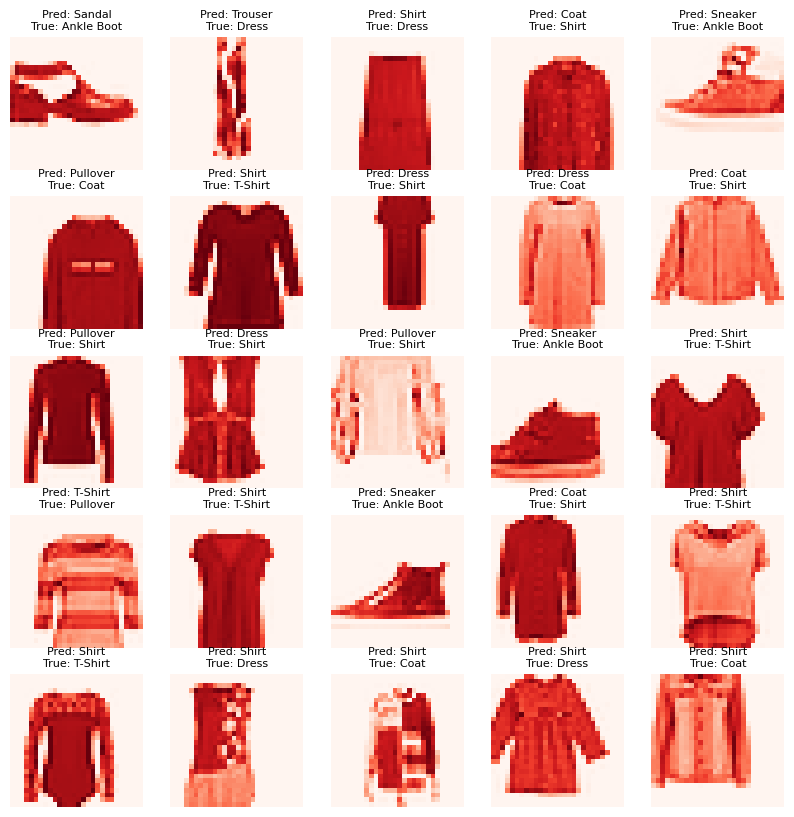

In [8]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import math

# BasicBlock 정의
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet 정의
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet-18 정의 함수
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

# Matplotlib 설정
%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 생성
class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.model = resnet18(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

model = FashionResNet().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')


Using PyTorch version: 2.3.0+cu118
Using GPU, device name: NVIDIA RTX A5000
Epoch [1/10], Loss: 0.5721, Accuracy: 78.88%
Epoch [2/10], Loss: 0.3847, Accuracy: 85.67%
Epoch [3/10], Loss: 0.3399, Accuracy: 87.32%
Epoch [4/10], Loss: 0.3095, Accuracy: 88.75%
Epoch [5/10], Loss: 0.2877, Accuracy: 89.55%
Epoch [6/10], Loss: 0.2726, Accuracy: 90.01%
Epoch [7/10], Loss: 0.2587, Accuracy: 90.55%
Epoch [8/10], Loss: 0.2145, Accuracy: 92.23%
Epoch [9/10], Loss: 0.2037, Accuracy: 92.62%
Epoch [10/10], Loss: 0.1981, Accuracy: 92.63%
Test Accuracy: 93.20%
Accuracy of T-shirt/top: 89.20%
Accuracy of Trouser: 99.10%
Accuracy of Pullover: 92.60%
Accuracy of Dress: 94.10%
Accuracy of Coat: 89.80%
Accuracy of Sandal: 98.00%
Accuracy of Shirt: 76.30%
Accuracy of Sneaker: 97.30%
Accuracy of Bag: 99.50%
Accuracy of Ankle boot: 96.10%


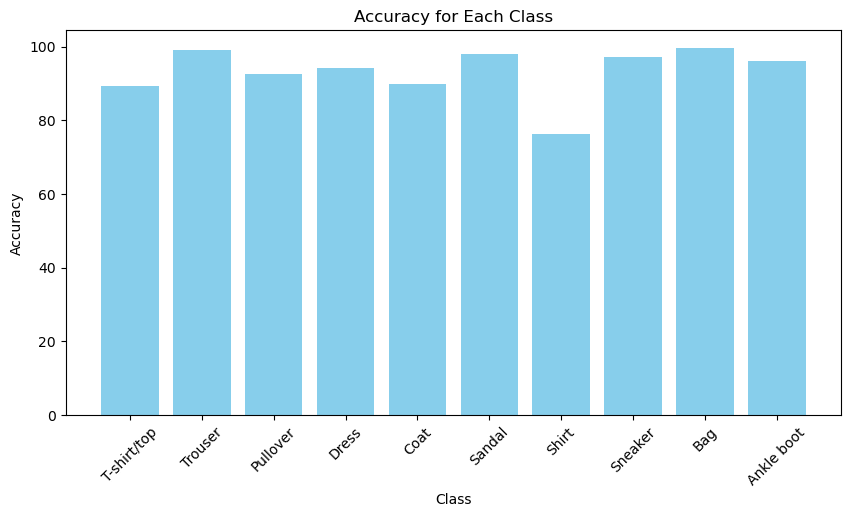

<Figure size 1000x1000 with 0 Axes>

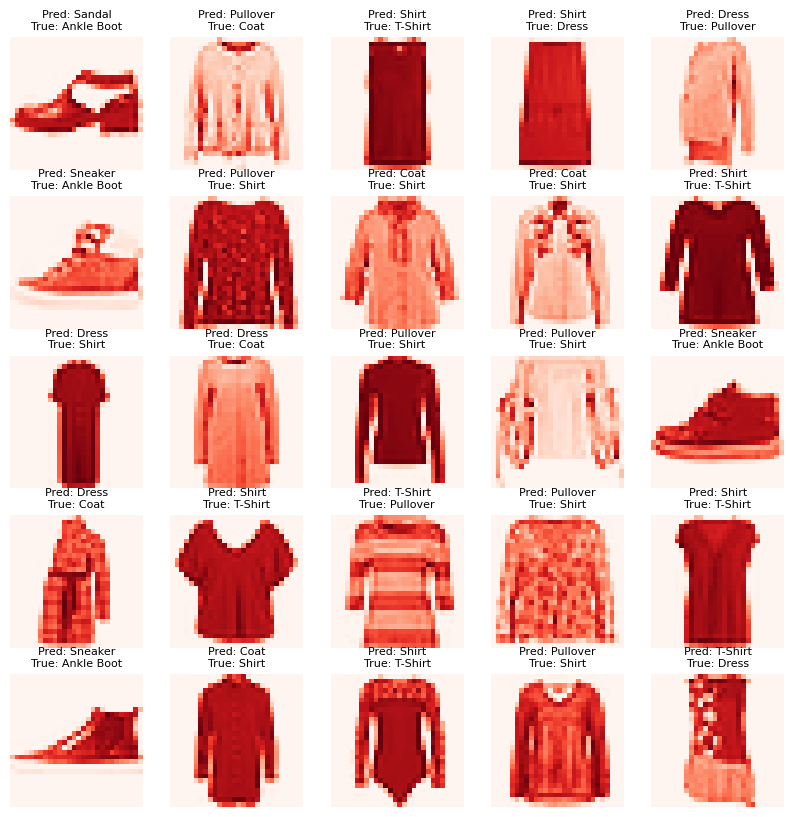

In [10]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import math

# BasicBlock 정의
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet 정의
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet-18 정의 함수
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

# Matplotlib 설정
%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 테스트 데이터 전처리
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 생성
class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.model = resnet18(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

model = FashionResNet().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()


Using PyTorch version: 2.3.0+cu118
Using GPU, device name: NVIDIA RTX A5000
Epoch [1/10], Loss: 0.5180, Accuracy: 80.97%
Epoch [2/10], Loss: 0.3318, Accuracy: 87.83%
Epoch [3/10], Loss: 0.2857, Accuracy: 89.55%
Epoch [4/10], Loss: 0.2575, Accuracy: 90.64%
Epoch [5/10], Loss: 0.2423, Accuracy: 91.18%
Epoch [6/10], Loss: 0.2257, Accuracy: 91.80%
Epoch [7/10], Loss: 0.2153, Accuracy: 92.15%
Epoch [8/10], Loss: 0.1701, Accuracy: 93.78%
Epoch [9/10], Loss: 0.1590, Accuracy: 94.21%
Epoch [10/10], Loss: 0.1553, Accuracy: 94.33%
Test Accuracy: 93.78%
Accuracy of T-shirt/top: 92.10%
Accuracy of Trouser: 98.50%
Accuracy of Pullover: 91.30%
Accuracy of Dress: 94.90%
Accuracy of Coat: 92.60%
Accuracy of Sandal: 98.40%
Accuracy of Shirt: 76.80%
Accuracy of Sneaker: 98.60%
Accuracy of Bag: 99.20%
Accuracy of Ankle boot: 95.40%


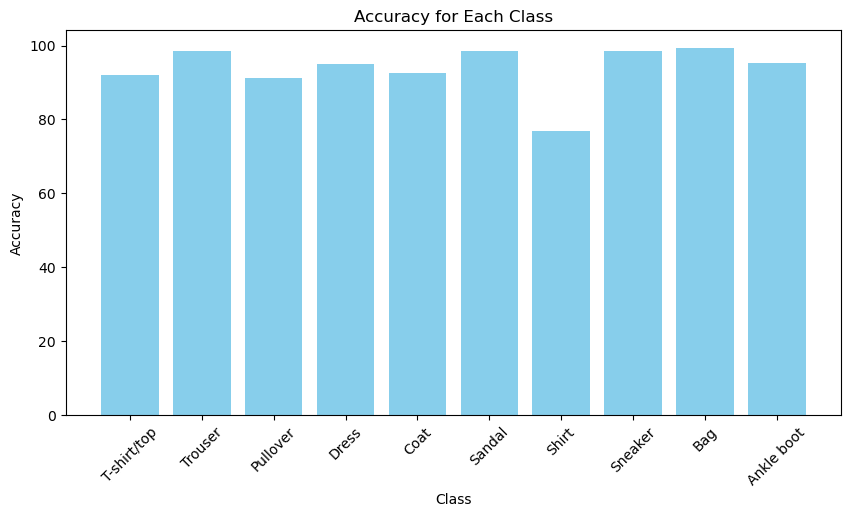

<Figure size 1000x1000 with 0 Axes>

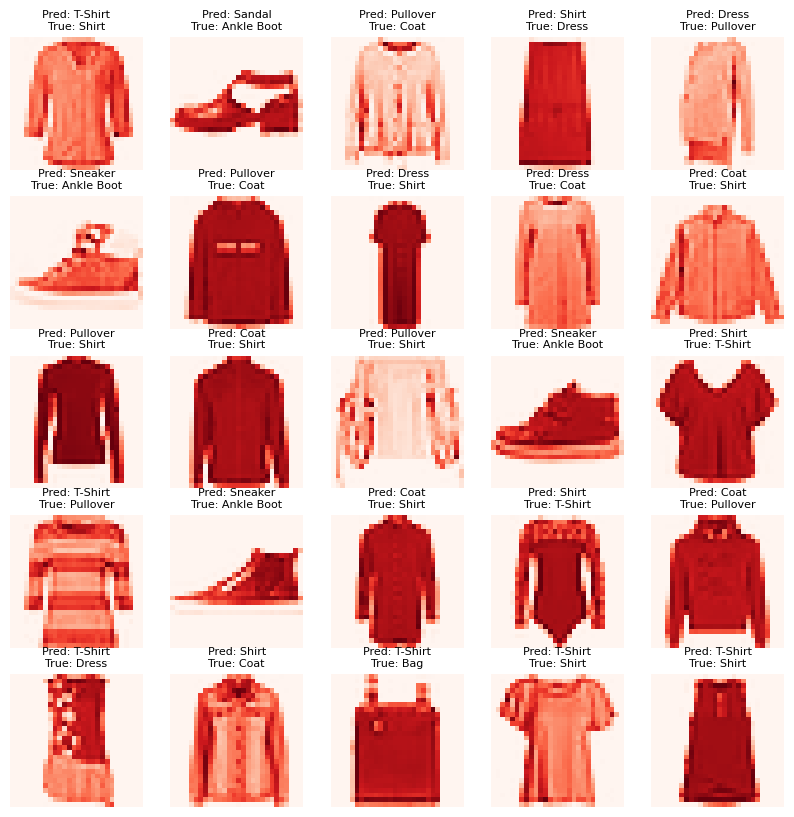

In [11]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import math

# BasicBlock 정의
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# ResNet 정의
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet-18 정의 함수
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

# Matplotlib 설정
%matplotlib inline

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

# 데이터 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 테스트 데이터 전처리
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 생성
class FashionResNet(nn.Module):
    def __init__(self):
        super(FashionResNet, self).__init__()
        self.model = resnet18(pretrained=False)
    
    def forward(self, x):
        return self.model(x)

model = FashionResNet().to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()


/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/piai/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch [1/20], Loss: 0.7239, Accuracy: 73.18%
Epoch [2/20], Loss: 0.5315, Accuracy: 80.18%
Epoch [3/20], Loss: 0.4700, Accuracy: 82.43%
Epoch [4/20], Loss: 0.4424, Accuracy: 83.55%
Epoch [5/20], Loss: 0.4162, Accuracy: 84.62%
Epoch [6/20], Loss: 0.3950, Accuracy: 85.17%
Epoch [7/20], Loss: 0.3764, Accuracy: 86.06%
Epoch [8/20], Loss: 0.3238, Accuracy: 87.92%
Epoch [9/20], Loss: 0.3040, Accuracy: 88.48%
Epoch [10/20], Loss: 0.2958, Accuracy: 88.92%
Epoch [11/20], Loss: 0.2911, Accuracy: 89.03%
Epoch [12/20], Loss: 0.2844, Accuracy: 89.27%
Epoch [13/20], Loss: 0.2843, Accuracy: 89.20%
Epoch [14/20], Loss: 0.2785, Accuracy: 89.54%
Epoch [15/20], Loss: 0.2720, Accuracy: 89.61%
Epoch [16/20], Loss: 0.2707, Accuracy: 89.71%
Epoch [17/20], Loss: 0.2687, Accuracy: 89.88%
Epoch [18/20], Loss: 0.2691, Accuracy: 89.83%
Epoch [19/20], Loss: 0.2663, Accuracy: 89.88%
Epoch [20/20], Loss: 0.2667, Accuracy: 89.81%
Test Accuracy: 90.74%
Accuracy of T-shirt/top: 84.50%
Accuracy of Trouser: 98.80%
Accurac

/home/piai/anaconda3/envs/yoon/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


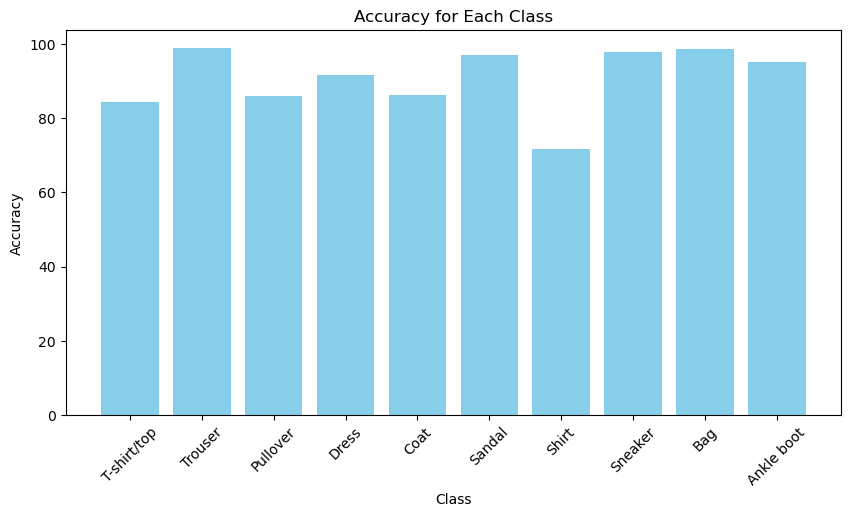

<Figure size 1000x1000 with 0 Axes>

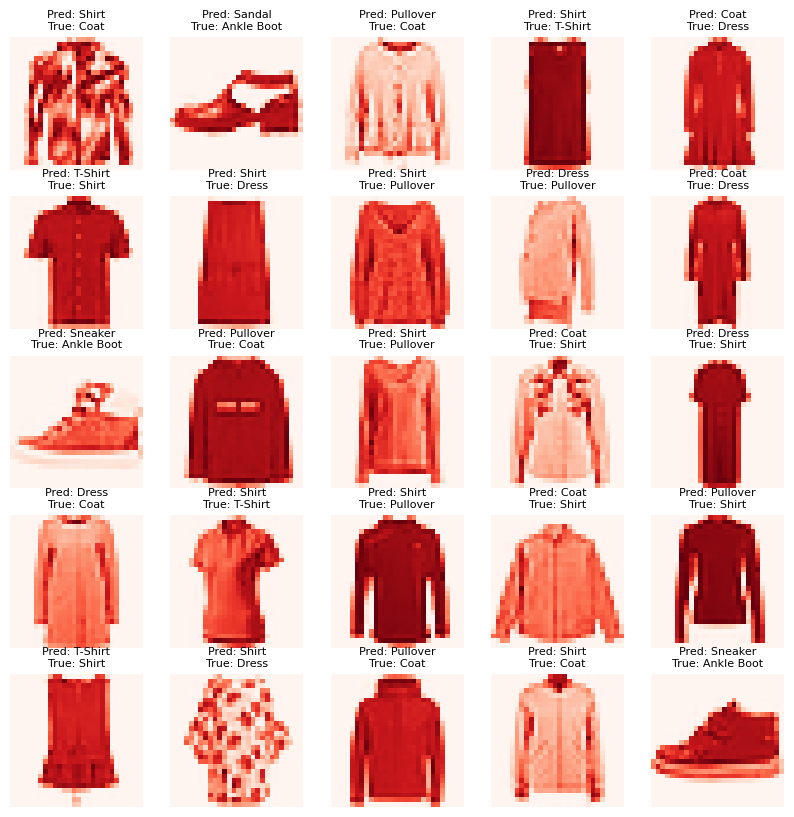

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 데이터 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 테스트 데이터 전처리
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 사전 학습된 ResNet18 모델 로드
model = models.resnet18(pretrained=True)

# 첫 번째 레이어를 수정하여 입력 채널을 1로 변경
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 출력 레이어를 수정하여 클래스 수를 10으로 변경
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 모델 학습 함수 정의
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

# 모델 평가 함수 정의
def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()


Epoch [1/10], Loss: 0.7171, Accuracy: 73.54%
Epoch [2/10], Loss: 0.5312, Accuracy: 80.31%
Epoch [3/10], Loss: 0.4629, Accuracy: 82.88%
Epoch [4/10], Loss: 0.4406, Accuracy: 83.76%
Epoch [5/10], Loss: 0.4068, Accuracy: 84.73%
Epoch [6/10], Loss: 0.3831, Accuracy: 85.62%
Epoch [7/10], Loss: 0.3814, Accuracy: 85.91%
Epoch [8/10], Loss: 0.3190, Accuracy: 88.06%
Epoch [9/10], Loss: 0.3004, Accuracy: 88.53%
Epoch [10/10], Loss: 0.2939, Accuracy: 88.81%
Test Accuracy: 90.16%
Accuracy of T-shirt/top: 84.40%
Accuracy of Trouser: 98.60%
Accuracy of Pullover: 83.80%
Accuracy of Dress: 91.10%
Accuracy of Coat: 85.60%
Accuracy of Sandal: 97.50%
Accuracy of Shirt: 70.90%
Accuracy of Sneaker: 97.70%
Accuracy of Bag: 98.10%
Accuracy of Ankle boot: 93.90%


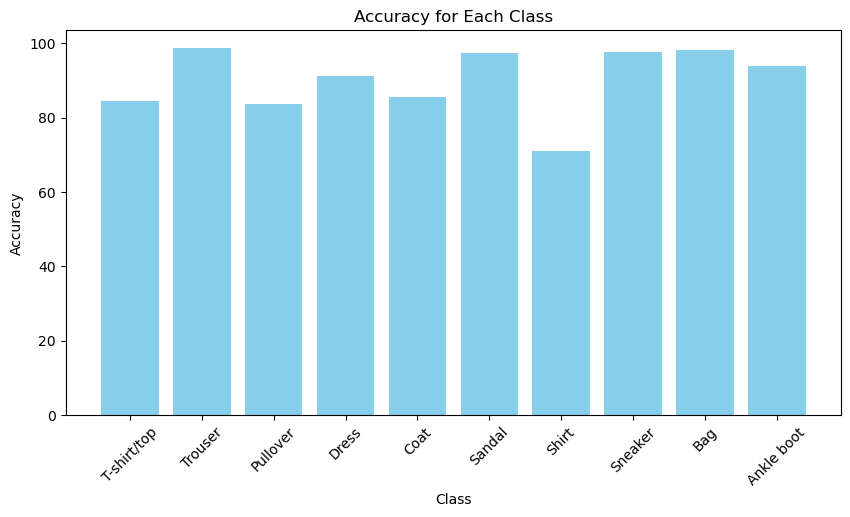

<Figure size 1000x1000 with 0 Axes>

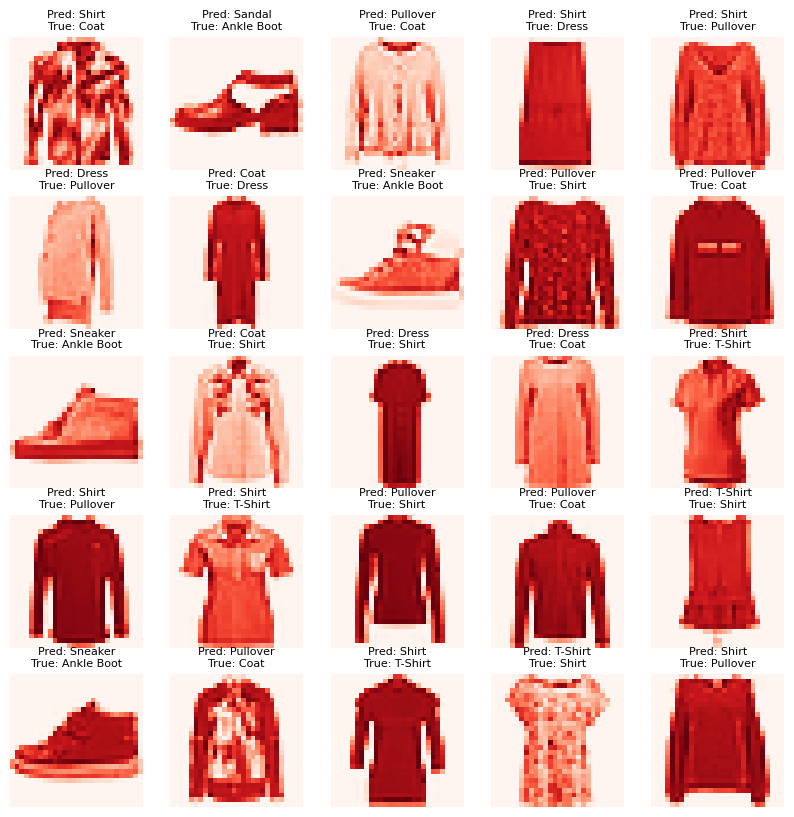

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 데이터 전처리
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 테스트 데이터 전처리
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 훈련 및 테스트 데이터셋 다운로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 사전 학습된 ResNet18 모델 로드
model = models.resnet18(pretrained=True)

# 첫 번째 레이어를 수정하여 입력 채널을 1로 변경
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 출력 레이어를 수정하여 클래스 수를 10으로 변경
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 정의
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 모델 학습 함수 정의
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 전방 전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()  # 학습률 스케줄러 업데이트
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

# 모델 평가 함수 정의
def evaluate_model(model, test_loader, device):
    model.eval()  # 평가 모드 설정
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    for i in range(10):
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    # 막대그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, [100 * class_correct[i] / class_total[i] for i in range(10)], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# 모델 학습 및 평가
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10)
evaluate_model(model, test_loader, device)

# 잘못 분류된 데이터 시각화
label_tags = {
    0: 'T-Shirt', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat', 
    5: 'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle Boot'
}

fig = plt.figure(figsize=(10, 10))
model.eval()
wrong_images = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        input_img, label = test_dataset[i]
        input_img = input_img.unsqueeze(dim=0).to(device)
        
        output = model(input_img)
        _, pred = torch.max(output, 1)
        
        if pred.item() != label:
            wrong_images.append((input_img.cpu(), pred.item(), label))

# 잘못 분류된 이미지 시각화
rows, columns = 5, 5
fig = plt.figure(figsize=(10, 10))

for i in range(min(len(wrong_images), rows * columns)):
    input_img, pred, label = wrong_images[i]
    input_img = input_img.squeeze()
    
    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'Pred: {label_tags[pred]}\nTrue: {label_tags[label]}', fontsize=8)
    plt.imshow(input_img, cmap='Reds')
    plt.axis('off')

plt.show()
